# Import Packages

In [44]:
# Core Libraries:
import pandas as pd
from pandas import DataFrame
import pickle
import numpy as np
from numpy import unique
#import re
#import os

#"""
# Google Colab
### Print Dataframe like Spreadsheet!
from google.colab import data_table
data_table.enable_dataframe_formatter()
#"""

#"""
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
#"""

## Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Pre-processing Libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline

## Modeling Libraries
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import textblob
from textblob import TextBlob

## Validation Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

## Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTANT NOTE About Pickled Data and Running this notebook in Google Colab
- Run the cells below that are commented-out the first time the notebooks is run in Google Colab.
- Adjust the file path as needed
- Data can usually be exported to your Google Colab home directory, e.g. `df.to_pickle('desc_nlp_done.pkl')`
- The file will not persist in memory in your runtime instance, so to preserve it, move it in the File tree menu from the home directory to, for example, in a folder on your Google Drive.
- Below you can observe I saved the cleaned data from my my second data cleaning notebook to `'/content/drive/MyDrive/capstone_data/ready_for_modeling.pkl'`

# Import Cleaned Data

In [28]:
#df_pristine = pd.read_pickle('/content/drive/MyDrive/capstone_data/ready_for_modeling.pkl')
#df = df_pristine.copy()

# NLP Pre-Processing:
- Process our unstructured text columns `description`, `neighborhood_overview` and `host_about` columns
- I use TextBlob to create a *polarity* and *subjectivity* for each unstructured text column.

## Description
- For each column I use a lambda function with `.apply` to produce a new column containing the given metric.

In [29]:
"""
df['description'] = df['description'].fillna('')
df['desc_polarity'] = df['description'].apply(lambda text: TextBlob(text).polarity)
df['desc_subjectivity'] = df['description'].apply(lambda text: TextBlob(text).subjectivity)
"""

"\ndf['description'] = df['description'].fillna('')\ndf['desc_polarity'] = df['description'].apply(lambda text: TextBlob(text).polarity)\ndf['desc_subjectivity'] = df['description'].apply(lambda text: TextBlob(text).subjectivity)\n"

## Neighborhood Overview

In [30]:
"""
df['neighborhood_overview'] = df['neighborhood_overview'].fillna('')
df['neigh_over_polarity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).polarity)
df['neigh_over_subjectivity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).subjectivity)
"""

"\ndf['neighborhood_overview'] = df['neighborhood_overview'].fillna('')\ndf['neigh_over_polarity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).polarity)\ndf['neigh_over_subjectivity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).subjectivity)\n"

## Host About

In [31]:
"""
df['host_about'] = df['host_about'].fillna('')
df['host_about_polarity'] = df['host_about'].apply(lambda text: TextBlob(text).polarity)
df['host_about_subjectivity'] = df['host_about'].apply(lambda text: TextBlob(text).subjectivity)
"""

"\ndf['host_about'] = df['host_about'].fillna('')\ndf['host_about_polarity'] = df['host_about'].apply(lambda text: TextBlob(text).polarity)\ndf['host_about_subjectivity'] = df['host_about'].apply(lambda text: TextBlob(text).subjectivity)\n"

# Pickle Subjectivity/Polarity Dataframe:

In [32]:
#df.to_pickle('desc_nlp_done.pkl')

# Read Subjectivity/Polarity Pickle:

In [33]:
# Read in dataframe with NLP column for description:
df_nlp_done = pd.read_pickle("/content/drive/MyDrive/capstone_data/desc_nlp_done.pkl")

In [34]:
df = df_nlp_done.copy()

# Explore Outliers:
- We can gather from the below `.describe()` that we have significant outliers `'accommodates', 'bedrooms', 'beds','maximum_nights', 'minimum_nights', 'maximum_nights'`
- Of particular concern is the max value of `maximum_nights` which at **2,147,483,647 days** or **5,883,516 years** *might* not be possible.

In [35]:
df[['price','accommodates', 'bedrooms', 'beds','minimum_nights', 'maximum_nights']].describe()

,price,accommodates,bedrooms,beds,minimum_nights,maximum_nights
count,274958.000000,274958.000000,205357.000000,272084.000000,274958.000000,2.749580e+05
mean,276.534806,4.347380,2.043286,2.417761,14.194764,8.483414e+03
std,935.930588,2.980081,1.277218,1.970968,26.725442,4.095757e+06
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
25%,96.000000,2.000000,1.000000,1.000000,2.000000,9.000000e+01
50%,155.000000,4.000000,2.000000,2.000000,3.000000,3.650000e+02
75%,264.000000,6.000000,3.000000,3.000000,30.000000,1.125000e+03
max,100000.000000,16.000000,50.000000,132.000000,1250.000000,2.147484e+09


## Explore impossible max value of `maximum_nights`
- According to this Business Insider article, "While Airbnb doesn't restrict how long properties can be rented for, most customers only book for short periods of time, with less than 20% of bookings being for longer than 30 days."
- For now, we'll create a cut-off over 1,125 days, which is about 2.7 years.
- You can see that removing the listings with ridiculously large numbers for `maximum_nights` would only eliminate 41 instances.

In [36]:
# Show listings sorted by descending maximum nights
DataFrame(df['maximum_nights'].value_counts()).sort_index(ascending=False)

,maximum_nights
2147483647,1
20000000,2
11250,1
10000,5
9999,3
...,...
5,1067
4,706
3,747
2,288


## Remove listings where `maximum_nights` >1125

In [37]:
df = df.drop(df[df['maximum_nights'] > 1125].index)

## Re-check .describe()'s output now that we've dropped listings with absurd number of nights:
- Because there are still many outliers, we'll try modeling with this data and next steps may be to find a way to either remove outliers, or segment the data based on geographic areas that would be easier to generalize.

In [38]:
df[['price','accommodates', 'bedrooms', 'beds','minimum_nights', 'maximum_nights']].describe()

,price,accommodates,bedrooms,beds,minimum_nights,maximum_nights
count,274917.000000,274917.000000,205333.000000,272043.000000,274917.000000,274917.000000
mean,276.544889,4.347490,2.043305,2.417838,14.182684,527.207503
std,935.994182,2.980055,1.277233,1.971019,26.579761,454.056799
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,96.000000,2.000000,1.000000,1.000000,2.000000,90.000000
50%,155.000000,4.000000,2.000000,2.000000,3.000000,365.000000
75%,264.000000,6.000000,3.000000,3.000000,30.000000,1125.000000
max,100000.000000,16.000000,50.000000,132.000000,1125.000000,1125.000000


# Distribution Plots
- Distribution plots can also help us visually understand outliers.
- We first log transform the data. Log-transformation is often used to address skewness of data, but as you can see, even with log transformation, price is severely right-skewed.
- `price` is definitely not normally-distributed in our data.

In [41]:
df_log = df.copy()

In [42]:
# Function for log transformation of the column
# Adapted from Career Foundary Blog Post: https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
def log_transform(df,col):
    for name in col:
        if (df[name] == 1.0).all(): # if all values are 1
            df[name + '_log'] = np.log(df[name]+1) # add 1 to avoid log(0)
        else:
            df[name + '_log'] = np.log(df[name]) # log transform
    df.info()

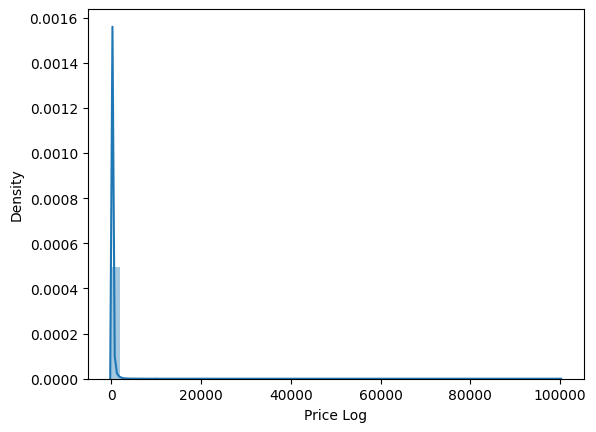

In [45]:
sns.distplot(df_log['price'], axlabel='Price Log');


# Create df for pipeline:
- Drop:
  - Free text columns we already converted to polarity and subjectivity:
    - `'description', 'neighborhood_overview', 'host_about'`
  - `amenities_keep` (the list of amenities we already transformed to boolean columns

In [127]:
df = df.drop(['description', 'neighborhood_overview', 'host_about', 'amenities_keep'], axis=1)

# Inspect Columns to OHE

## Categorical Columns:

In [129]:
data_table.enable_dataframe_formatter()
cat_cols = []
for col in range(df.shape[1]):
  if df[df.columns[col]].dtypes == 'object':
    cat_cols.append(df.columns[col])
print("Categorical Columns")
print()
for col in cat_cols:
  print(col)
cat_df = df[cat_cols]
print()
cat_df.apply(lambda cat_df: cat_df.sample(5, random_state=0))

Categorical Columns

property_type
room_type
city
state



,property_type,room_type,city,state
11009,Entire condo,Entire homeapt,Hawaii,Hawaii
17247,Entire condo,Entire homeapt,Hawaii,Hawaii
227719,Entire condo,Entire homeapt,San Diego,California
26919,Entire rental unit,Entire homeapt,Hawaii,Hawaii
244268,Entire rental unit,Entire homeapt,Broward County,Florida


In [130]:
# There are no nulls in the categorical columns
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274949 entries, 0 to 274957
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   property_type  274949 non-null  object
 1   room_type      274949 non-null  object
 2   city           274949 non-null  object
 3   state          274949 non-null  object
dtypes: object(4)
memory usage: 10.5+ MB


# Take aways from previewing this data

In [131]:
DataFrame(df['property_type'].value_counts())

,property_type
Entire rental unit,71604
Entire home,60262
Entire condo,34401
Private room in home,24538
Private room in rental unit,17590
...,...
Riad,1
Private room in bus,1
Shared room in nature lodge,1
Shared room in castle,1


In [132]:
DataFrame(df['room_type'].value_counts())

,room_type
Entire homeapt,208467
Private room,63295
Shared room,2379
Hotel room,808


In [133]:
DataFrame(df['city'].value_counts())

,city
Los Angeles,44592
New York City,38792
Hawaii,33338
Broward County,17914
Clark County,16638
Austin,14861
San Diego,12496
Nashville,8583
Chicago,8528
Santa Clara County,6852


In [134]:
DataFrame(df['state'].value_counts())

,state
California,72075
New York,39730
Hawaii,33338
Texas,22295
Florida,17914
Nevada,16638
Tennessee,8583
Illinois,8528
Washington,6823
Louisiana,6783


## Boolean Columns:

In [135]:
bool_cols = []
for col in range(df.shape[1]):
  nunique_vals = df.iloc[:,col].nunique()
  if nunique_vals == 2:
    bool_cols.append(df.columns[col])
print("Boolean Columns")
print()
for col in bool_cols:
  print(col)
bool_df = df[bool_cols]
print()
bool_df.apply(lambda bool_df: bool_df.sample(5, random_state=0))

Boolean Columns

host_has_profile_pic
host_identity_verified
instant_bookable
license_bool
is_shared_bathroom
air_conditioning
kitchen
wifi
free_park_prem
pets_allowed
pool



,host_has_profile_pic,host_identity_verified,instant_bookable,license_bool,is_shared_bathroom,air_conditioning,kitchen,wifi,free_park_prem,pets_allowed,pool
11009,1,1,1,1,0,1,1,1,0,0,1
17247,1,1,0,1,0,1,1,1,1,0,1
227719,1,1,0,1,0,0,1,1,0,1,0
26919,1,1,1,0,0,1,1,1,1,0,0
244268,1,1,0,0,0,1,1,1,0,0,1


In [136]:
# There are no nulls in the boolean columns:
df[bool_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274949 entries, 0 to 274957
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   host_has_profile_pic    274949 non-null  int64
 1   host_identity_verified  274949 non-null  int64
 2   instant_bookable        274949 non-null  int64
 3   license_bool            274949 non-null  int64
 4   is_shared_bathroom      274949 non-null  int64
 5   air_conditioning        274949 non-null  int64
 6   kitchen                 274949 non-null  int64
 7   wifi                    274949 non-null  int64
 8   free_park_prem          274949 non-null  int64
 9   pets_allowed            274949 non-null  int64
 10  pool                    274949 non-null  int64
dtypes: int64(11)
memory usage: 25.2 MB


## Numeric Columns (Excluding `price` and `bool_cols`)

In [137]:
num_cols = []
for col in range(df.shape[1]):
  if df[df.columns[col]].dtypes != 'object' and df.columns[col] not in bool_cols:
    num_cols.append(df.columns[col])
num_cols.remove('price')
print("Numeric Columns")
print()
for col in num_cols:
  print(col)
num_df = df[num_cols]
print()
num_df.apply(lambda num_df: num_df.sample(5, random_state=0))

Numeric Columns

latitude
longitude
accommodates
bedrooms
beds
minimum_nights
maximum_nights
bathrooms
desc_polarity
desc_subjectivity
neigh_over_polarity
neigh_over_subjectivity
host_about_polarity
host_about_subjectivity



,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,bathrooms,desc_polarity,desc_subjectivity,neigh_over_polarity,neigh_over_subjectivity,host_about_polarity,host_about_subjectivity
11009,20.705050,-156.446500,4,2.0,2.0,5,60,2.0,0.502381,0.416667,0.000000,0.000000,0.096780,0.333712
17247,20.689390,-156.437100,3,1.0,2.0,1,60,1.0,0.282420,0.488749,0.400000,0.400000,0.000000,0.000000
227719,32.712887,-117.160767,12,2.0,3.0,3,365,1.0,0.244591,0.472303,0.179758,0.264333,0.000000,0.000000
26919,19.579621,-155.003520,2,NaN,1.0,31,365,1.0,0.189063,0.468750,0.000000,0.000000,0.417361,0.560417
244268,26.133950,-80.121380,2,1.0,1.0,3,1125,1.0,0.169176,0.642912,0.023810,0.519048,0.000000,0.000000


In [138]:
# There are nulls in bedrooms, beds, bathrooms, but relatively few
# We'll use a simple imputer for the numeric col nulls
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274949 entries, 0 to 274957
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   latitude                 274949 non-null  float64
 1   longitude                274949 non-null  float64
 2   accommodates             274949 non-null  int64  
 3   bedrooms                 205348 non-null  float64
 4   beds                     272075 non-null  float64
 5   minimum_nights           274949 non-null  int64  
 6   maximum_nights           274949 non-null  int64  
 7   bathrooms                274607 non-null  float64
 8   desc_polarity            274949 non-null  float64
 9   desc_subjectivity        274949 non-null  float64
 10  neigh_over_polarity      274949 non-null  float64
 11  neigh_over_subjectivity  274949 non-null  float64
 12  host_about_polarity      274949 non-null  float64
 13  host_about_subjectivity  274949 non-null  float64
dtypes: f

# Data Pre-Processing and Pipeline and validation metrics set-up

## Add Intercept to Data:
- We can avoid biased residuals if we add an intercept
- https://medium.com/datascienceray/why-add-an-intercept-column-into-datasets-a2385cdb33bc

In [139]:
df['intercept'] = 1

In [140]:
df['intercept'].value_counts()

1    274949
Name: intercept, dtype: int64

## Define Modeling Class ModelWithCV()
- Use this class to execute cross validation with 5 folds on each pipeline and return RMSE, MSE, MAE and R2

In [141]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()

    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.

        Args:
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)
        '''

        cv_X = X if X else self.X
        cv_y = y if y else self.y

        # MSE Results:
        self.cv_mse_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring ='neg_mean_squared_error')
        self.cv_mse_mean = np.mean(self.cv_mse_results)
        self.cv_mse_median = np.median(self.cv_mse_results)
        self.cv_mse_std = np.std(self.cv_mse_results)

        # MAE Results:
        self.cv_mae_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring ='neg_mean_absolute_error')
        self.cv_mae_mean = np.mean(self.cv_mae_results)
        self.cv_mae_median = np.median(self.cv_mae_results)
        self.cv_mae_std = np.std(self.cv_mae_results)

        # RMSE Results:
        self.cv_rmse_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring ='neg_root_mean_squared_error')
        self.cv_rmse_mean = np.mean(self.cv_rmse_results)
        self.cv_rmse_median = np.median(self.cv_rmse_results)
        self.cv_rmse_std = np.std(self.cv_rmse_results)

        # R2 Results:
        self.cv_r2_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring = 'r2')
        self.cv_r2_mean = np.mean(self.cv_r2_results)
        self.cv_r2_median = np.median(self.cv_r2_results)
        self.cv_r2_std = np.std(self.cv_r2_results)

    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            R-Squared: {self.cv_r2_mean:.5f} ± {self.cv_r2_std:.5f}
            Root Mean Squared Error: {self.cv_rmse_mean*-1} ± {self.cv_rmse_std:.5f}
            Mean Absolute Error: {self.cv_mae_mean*-1} ± {self.cv_mae_std:.5f}
            Mean Squared Error: {self.cv_mse_mean*-1} ± {self.cv_mse_std:.5f}
            10-fold Cross Validation Scores: {self.cv_r2_results}
        ''')
        print(cv_summary)

## Pipeline Set-up

### Boolean features don't need to be scaled
- so we will use 'remainder='passthrough'' To indicate to compiler to let them through pipeline without transformations.

In [144]:
print(cat_cols)

['property_type', 'room_type', 'city', 'state']


In [145]:
print(bool_cols)

['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'license_bool', 'is_shared_bathroom', 'air_conditioning', 'kitchen', 'wifi', 'free_park_prem', 'pets_allowed', 'pool']


In [146]:
print(num_cols)

['latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'bathrooms', 'desc_polarity', 'desc_subjectivity', 'neigh_over_polarity', 'neigh_over_subjectivity', 'host_about_polarity', 'host_about_subjectivity']


### Pipeline for numerics:
- We need to scale our numeric values because we're going to use

In [147]:
# Pipeline for numerics (SCALE data):
numpipe = Pipeline([
    ('stan_scale', StandardScaler()),
    ('num_impute', SimpleImputer(strategy='median'))
])


### Pipeline for Categoricals:

In [148]:
# Pipeline for categorical feature (One-Hot-Encode):
catpipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) # Using handle_unknown param en lieu of stratify during train-test-split
])

### We now have our numeric and categorical pipelines.
- Since we don't have any nulls, and binary features don't need to be transformed or one-hot-encoded,
- Our binary features don't need any transformations, so we will use `remainder='passthrough'` to let them through.
- Next step is to handle columns holistically with `ColumnTransformer`

### Create Column Transformer for Pipeline

In [149]:
# We will use our pipeline objects as transformer argument for ColumnTransformer
# our transformer is a tuple and includes a `columns` argument

ColTrans = ColumnTransformer(transformers=[
    ('numerics', numpipe, num_cols),
    ('categoricals', catpipe, cat_cols)
], remainder='passthrough')

## Train Test Split
- The advantages of creating 2 splits is the hold-out testing set that's kept pristine until we train and test our final model.

### First Split

In [142]:
# Create X (predictors) and y (target) variables:
X_1 = df.drop('price', axis=1)
y_1 = df['price']

# Split Data into train and test:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state=666)

### Second Split

In [143]:
# Split Data into train and test:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_1_train, y_1_train, random_state=666)


# Model #1: Baseline Dummy

In [150]:
# Create Dummy Model Pipeline
dumpipe = Pipeline([
    ('ct', ColTrans),
    ('dummy', DummyRegressor(strategy='median'))
])

In [151]:
# Fit the dummy regressor to the training data:
dumpipe.fit(X_2_train, y_2_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('dummy', DummyRegressor())])

## Dummy Regressor Cross validation on Training Data

In [152]:

# Now let's instantiate a dummy pipeline model and fit via inheritance from the ModelWithCV class:
dum_pipe_cv = ModelWithCV(
    dumpipe,
    model_name='dummy',
    X=X_2_train,
    y=y_2_train,
)

In [153]:
dum_pipe_cv.print_cv_summary()

CV Results for `dummy` model:
            R-Squared: -0.00006 ± 0.00003
            Root Mean Squared Error: 757.9656009437507 ± 62.95653
            Mean Absolute Error: 212.37077091586556 ± 3.95823
            Mean Squared Error: 578475.3770885549 ± 95521.56139
            10-fold Cross Validation Scores: [-5.25503870e-05 -8.47310910e-05 -1.85075212e-05 -3.34330882e-05
 -8.88000725e-05]
        


## Dummy Regressor Results on Test Data:
- Adapted from: https://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_sklearn_pipeline.html

In [154]:
y_1_test_pred_dumpipe = dumpipe.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, y_1_test_pred_dumpipe)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_dumpipe, squared=False)))
print("MAE:      {:.5f}".format(mean_absolute_error(y_1_test, y_1_test_pred_dumpipe)))
print("MSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_dumpipe)))


R2 score: -0.00000
RMSE:      734.22926
MAE:      212.14700
MSE:      539092.59999


# Model #2: Lasso ("At least r2 isn't negative") Regression
- Cite the study and can mitigate multicoll
- Dive into assumptions: multi and heteroscedasticity
- You will violate some, discuss

In [155]:
# Create Lasso Model Pipeline
lassopipe = Pipeline([
    ('ct', ColTrans),
    ('lasso', Lasso())
])

In [156]:
lassopipe.fit(X_1_train, y_1_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('lasso', Lasso())])

In [157]:
lassopipe_cv = ModelWithCV(
    lassopipe,
    model_name='lasso',
    X=X_2_train,
    y=y_2_train,
)

In [158]:
lassopipe_cv.print_cv_summary()

CV Results for `lasso` model:
            R-Squared: -1.63596 ± 3.50560
            Root Mean Squared Error: 1073.8389899835768 ± 759.99027
            Mean Absolute Error: 175.52362087771158 ± 8.16702
            Mean Squared Error: 1730715.3911948844 ± 2490858.98257
            10-fold Cross Validation Scores: [ 0.10105318 -8.64712327  0.12661158  0.11052387  0.12915233]
        


#### Compare to Dummy Model CV Results:
- CV Results for `dummy` model:
  - R-Squared: -0.00004 ± 0.00004
  - Root Mean Squared Error: 951.4114265294854 ± 137.36254
  - Mean Absolute Error: 219.10723721594718 ± 4.37318
  - Mean Squared Error: 924052.1695826652 ± 257613.42217
  - 10-fold Cross Validation Scores: [-9.71921643e-07 -1.29942088e-05 -1.19020139e-04 -8.16565079e-06
 -3.91309529e-05]

## Lasso Regressor Results on Test Data:
- Adapted from: https://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_sklearn_pipeline.html

In [159]:
y_1_test_pred_lassopipe = lassopipe.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, y_1_test_pred_lassopipe)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_lassopipe, squared=False)))
print("MAE:      {:.5f}".format(mean_absolute_error(y_1_test, y_1_test_pred_lassopipe)))
print("MSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_lassopipe)))


R2 score: 0.12839
RMSE:      685.47786
MAE:      174.15012
MSE:      469879.89379


#### Compare to Dummy Regressor Results on Test:
- R2 score: -0.00000
- RMSE:      938.60851
- MAE:      221.39243
- MSE:      880985.93413

# Model #3: RidgeRegression

In [160]:
# Create Ridge Model Pipeline

ridgepipe = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge())
])

In [161]:
ridgepipe.fit(X_1_train, y_1_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('ridge', Ridge())])

In [162]:
ridgepipe_cv = ModelWithCV(
    ridgepipe,
    model_name='ridge',
    X=X_2_train,
    y=y_2_train,
)

In [163]:
ridgepipe_cv.print_cv_summary()

CV Results for `ridge` model:
            R-Squared: -2.00270 ± 4.24872
            Root Mean Squared Error: 1119.8725885043602 ± 855.68861
            Mean Absolute Error: 177.83276028766733 ± 8.73474
            Mean Squared Error: 1986317.619413446 ± 3007317.58330
            10-fold Cross Validation Scores: [  0.10702907 -10.50012577   0.13292184   0.11418038   0.1324702 ]
        


#### Compare to Lasso CV Results:
- CV Results for `lasso` model:
  - R-Squared: 0.07817 ± 0.02241
  - Root Mean Squared Error: 914.9255694772726 ± 142.04926
  - Mean Absolute Error: 178.94954557628338 ± 3.38633
  - Mean Squared Error: 857266.7906274914 ± 255512.36661
  - 10-fold Cross Validation Scores: [0.10253108 0.05482181 0.06086769 0.06463992 0.1079843 ]

## *Ridge* Regressor Results on Test Data:
- Adapted from: https://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_sklearn_pipeline.html

In [164]:
y_1_test_pred_ridgepipe = ridgepipe.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, y_1_test_pred_ridgepipe)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_ridgepipe, squared=False)))
print("MAE:      {:.5f}".format(mean_absolute_error(y_1_test, y_1_test_pred_ridgepipe)))
print("MSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_ridgepipe)))

R2 score: 0.13243
RMSE:      683.88732
MAE:      175.97362
MSE:      467701.87010


## Compare to Lasso Results on Test Data:
- R2 score: 0.08524
- RMSE:      897.71416
- MAE:      178.93013
- MSE:      805890.70612

# Final Model: Grid-Searched Ridge Regression
- why

## Print Available Hyper-parameters for Ridge Regression:

In [165]:
# Print all of my ridge() object's hyperparameters:
for key in ridgepipe.get_params().keys():
    if key.startswith('ridge__'):
        print(key)

ridge__alpha
ridge__copy_X
ridge__fit_intercept
ridge__max_iter
ridge__positive
ridge__random_state
ridge__solver
ridge__tol


In [166]:
ridge_search_space = {'ridge__alpha':[.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40],
                      'ridge__solver':['auto', 'svd', 'lsqr', 'sparse_output', 'saga']
                      }

In [167]:
ridge_grid_search = GridSearchCV(ridgepipe, ridge_search_space, n_jobs=-1, cv=5, return_train_score=True)

In [168]:
#!pip install ipython-autotime
#%load_ext autotime

In [169]:
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime

In [170]:
%%time
#ridge_grid_search.fit(X_2_train,y_2_train)

CPU times: user 14 µs, sys: 10 µs, total: 24 µs
Wall time: 7.15 µs


In [171]:
#print('Best Hyperparameters: %s' % ridge_grid_search.best_params_)

## Use best alpha to evaluate

In [172]:
# Create Ridge Model with Best HyperParameters Pipeline
# Best Hyperparameters: {'ridge__alpha': 10, 'ridge__solver': 'svd'}

ridge_grid_use_best_alpha = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge(alpha=10, solver='svd'))
])

In [173]:
ridge_grid_use_best_alpha.fit(X_1_train, y_1_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('ridge', Ridge(alpha=10, solver='svd'))])

In [174]:
ridge_grid_use_best_alpha_cv = ModelWithCV(
    ridge_grid_use_best_alpha,
    model_name='ridge grid best alpha',
    X=X_1_train,
    y=y_1_train,
)

In [175]:
ridge_grid_use_best_alpha_cv.print_cv_summary()

CV Results for `ridge grid best alpha` model:
            R-Squared: -2.85973 ± 5.96845
            Root Mean Squared Error: 1226.7288255495741 ± 1016.08567
            Mean Absolute Error: 180.3201686155739 ± 8.15663
            Mean Squared Error: 2537293.696905061 ± 4037916.88123
            10-fold Cross Validation Scores: [  0.14329876 -14.79661035   0.12243494   0.10890417   0.12333728]
        


CV Results for `ridge` model:
- R-Squared: 0.08069 ± 0.02296
- Root Mean Squared Error: 913.7090890478427 ± 142.05391
- Mean Absolute Error: 181.1914741839282 ± 3.36074
- Mean Squared Error: 855043.613752242 ± 255034.97026
- 10-fold Cross Validation Scores: [0.10349199 0.05722112 0.06379324 0.06574233 0.11318313]

In [176]:
y_1_test_pred_ridge_grid_use_best_alpha = ridge_grid_use_best_alpha.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, y_1_test_pred_ridge_grid_use_best_alpha)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_ridge_grid_use_best_alpha, squared=False)))
print("MAE:      {:.5f}".format(mean_absolute_error(y_1_test, y_1_test_pred_ridge_grid_use_best_alpha)))
print("MSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_ridge_grid_use_best_alpha)))

R2 score: 0.13231
RMSE:      683.93321
MAE:      175.91464
MSE:      467764.63617


# Final Evaluation

In [177]:
# Create Ridge Model with Best HyperParameters Pipeline
# Best Hyperparameters: {'ridge__alpha': 10, 'ridge__solver': 'svd'}

final_pipe = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge(alpha=10, solver='svd'))
])

In [178]:
final_pipe.fit(X_1_train, y_1_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('ridge', Ridge(alpha=10, solver='svd'))])

In [179]:
final_pipe_cv = ModelWithCV(
    ridge_grid_use_best_alpha,
    model_name='final model',
    X=X_2_train,
    y=y_2_train,
)

In [180]:
final_pipe_cv.print_cv_summary()

CV Results for `final model` model:
            R-Squared: -2.00306 ± 4.24911
            Root Mean Squared Error: 1119.9587832964403 ± 855.72027
            Mean Absolute Error: 177.77426587982066 ± 8.70825
            Mean Squared Error: 1986564.853573089 ± 3007588.58662
            10-fold Cross Validation Scores: [  0.10663173 -10.50125161   0.13241171   0.11398839   0.13290596]
        


CV Results for `ridge` model:
- R-Squared: 0.08069 ± 0.02296
- Root Mean Squared Error: 913.7090890478427 ± 142.05391
- Mean Absolute Error: 181.1914741839282 ± 3.36074
- Mean Squared Error: 855043.613752242 ± 255034.97026
- 10-fold Cross Validation Scores: [0.10349199 0.05722112 0.06379324 0.06574233 0.11318313]

## Final Model Test Results on Hold-Out Data

In [181]:
final_model_pred = final_pipe.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, final_model_pred)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, final_model_pred, squared=False)))
print("MAE:      {:.5f}".format(mean_absolute_error(y_1_test, final_model_pred)))
print("MSE:      {:.5f}".format(mean_squared_error(y_1_test, final_model_pred)))

R2 score: 0.13260
RMSE:      683.82123
MAE:      174.40684
MSE:      467611.47121


## Final Evaluation

# Fit Final Model on All Data

In [ ]:
final_pipe_train_all = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge(alpha=10, solver='svd'))
])

In [ ]:
final_pipe_train_all.fit(X, y)

# Conclusion